In [1]:
import time
import numpy as np
import torch

from sbi import utils as utils
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import temporal_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [3]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Temporal SIR

In [4]:
temp_sir = temporal_sir.TemporalSIR()

## Data generation

In [ ]:
# DON'T NEED TO RUN AGAIN IF YOU ALREADY GENERATED THE REFERENCE DATA
N = 50000

temp_sir_theta_npe_large = temp_sir.sample_theta([N]).reshape(-1, temp_sir.theta_dim)
temp_sir_x_npe_large = torch.empty([N, temp_sir.x_dim])
for i in range(N):
    temp_sir_x_npe_large[i, :] = temp_sir(temp_sir_theta_npe_large[i])

temp_sir_obs_theta = torch.tensor([0.5, 0.5])
temp_sir_obs_x = temp_sir(temp_sir_obs_theta)

torch.save(temp_sir_x_npe_large, "data/temp_sir_x_npe_large.pt")
torch.save(temp_sir_theta_npe_large, "data/temp_sir_theta_npe_large.pt")
torch.save(temp_sir_obs_x, "data/temp_sir_obs_x.pt")
torch.save(temp_sir_obs_theta, "data/temp_sir_obs_theta.pt")

## Load data

In [5]:
temp_sir_x_npe_large = torch.load("data/temp_sir_x_npe_large.pt")
temp_sir_theta_npe_large = torch.load("data/temp_sir_theta_npe_large.pt")

temp_sir_obs_x = torch.load("data/temp_sir_obs_x.pt")
temp_sir_obs_theta = torch.load("data/temp_sir_obs_theta.pt")

## Fit GP

In [6]:
n_train_pair = 500 # number of pairs used to fit GP
n_rep = 20 # number of repeats to get the average cost

In [31]:
X = temp_sir_theta_npe_large[:n_train_pair]

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(temp_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = (et - st) / n_rep

# save GP training samples
torch.save(X, "data/temp_sir_gp_x.pt")
torch.save(times_train, "data/temp_sir_gp_y.pt")

In [33]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')

torch.save({'model_state_dict': model.state_dict(), 'likelihood_state_dict': likelihood.state_dict()}, 'data/temp_sir_gp.pth')

Iter 1/200 - Loss: 0.754936158657074
Iter 2/200 - Loss: 0.7175566554069519
Iter 3/200 - Loss: 0.6794660091400146
Iter 4/200 - Loss: 0.6406698226928711
Iter 5/200 - Loss: 0.6011747717857361
Iter 6/200 - Loss: 0.5609723925590515
Iter 7/200 - Loss: 0.520072340965271
Iter 8/200 - Loss: 0.47849100828170776
Iter 9/200 - Loss: 0.4362379014492035
Iter 10/200 - Loss: 0.3933223783969879
Iter 11/200 - Loss: 0.3497641086578369
Iter 12/200 - Loss: 0.3055850863456726
Iter 13/200 - Loss: 0.2608034610748291
Iter 14/200 - Loss: 0.21543847024440765
Iter 15/200 - Loss: 0.16951702535152435
Iter 16/200 - Loss: 0.12306603789329529
Iter 17/200 - Loss: 0.07610797137022018
Iter 18/200 - Loss: 0.028669554740190506
Iter 19/200 - Loss: -0.019217833876609802
Iter 20/200 - Loss: -0.06752941757440567
Iter 21/200 - Loss: -0.11623870581388474
Iter 22/200 - Loss: -0.16531427204608917
Iter 23/200 - Loss: -0.21473126113414764
Iter 24/200 - Loss: -0.26446259021759033
Iter 25/200 - Loss: -0.31447893381118774
Iter 26/200 - 

In [7]:
state_dicts = torch.load('data/temp_sir_gp.pth')   # Load GP params

# Load GP data
X = torch.load("data/temp_sir_gp_x.pt")
times_train = torch.load("data/temp_sir_gp_y.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [7]:
N = 50
n_rep = 20

beta = torch.linspace(0.1, 1, N)
beta_fixed = 1

gamma_fixed = 0.1
gamma = torch.linspace(0.1, 1, N)

beta_fixed_combined = beta_fixed * torch.ones_like(gamma)
combination_beta_fixed_gamma = torch.stack((beta_fixed_combined, gamma), dim=1)

gamma_fixed_combined = gamma_fixed * torch.ones_like(beta)
combination_beta_gamma_fixed = torch.stack((beta, gamma_fixed_combined), dim=1)

In [10]:
times_vs_beta = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_gamma_fixed[i])
    et = time.time()
    times_vs_beta[i] = (et - st) / n_rep

times_vs_gamma = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_fixed_gamma[i])
    et = time.time()
    times_vs_gamma[i] = (et - st) / n_rep

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_beta = likelihood(model(combination_beta_gamma_fixed)).mean
    observed_pred_gamma = likelihood(model(combination_beta_fixed_gamma)).mean

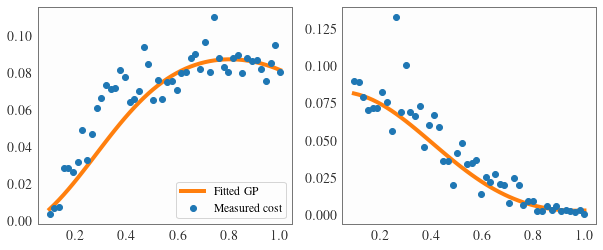

In [13]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(beta, observed_pred_beta, label="Fitted GP", color="C1", linewidth=4, zorder=0)
plt.scatter(beta, times_vs_beta, label="Measured cost")
plt.legend()

plt.subplot(1,2,2)
plt.plot(gamma, observed_pred_gamma, label="Fitted GP", color="C1", linewidth=4, zorder=0)
plt.scatter(gamma, times_vs_gamma, label="Measured cost")
plt.show()

In [14]:
prior_start = torch.tensor([0.1, 1.0]).reshape(-1, 2)
prior_end = torch.tensor([1.0, 0.1]).reshape(-1, 2)

g_min = likelihood(model(prior_start)).mean
g_max = likelihood(model(prior_end)).mean

print("g_min with k=0.5: ", (g_min ** 0.5).item())
print("g_min with k=1: ", (g_min ** 1).item())
print("g_min with k=2: ", (g_min ** 2).item())

print("g_max with k=0.5: ", (g_max ** 0.5).item())
print("g_max with k=1: ", (g_max ** 1).item())
print("g_max with k=2: ", (g_max ** 2).item())

g_min with k=0.5:  0.014827649109065533
g_min with k=1:  0.00021985918283462524
g_min with k=2:  4.833805888893039e-08
g_max with k=0.5:  0.2857629060745239
g_max with k=1:  0.0816604346036911
g_max with k=2:  0.006668426562100649


In [15]:
prior_start = torch.tensor([0.1, 1.0]).reshape(-1, 2)
k = 1

num_sim = 5000
theta_tilde = torch.zeros([num_sim, 2])
count = 0
while count < num_sim:
    theta = temp_sir.sample_theta([1]).reshape(-1, 2)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1
w = likelihood(model(theta_tilde)).mean.detach() ** k

theta_prior = temp_sir.sample_theta([num_sim]).reshape(-1, 2)

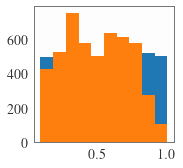

In [16]:
plt.hist(theta_prior.detach().numpy()[:, 0], bins=10)
plt.hist(theta_tilde.detach().numpy()[:, 0], bins=10)
plt.show()

## CEG ESS

In [23]:
num_sim = 10000
num_repeats = 2
k = np.array([0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]) # Exponent of the penaly function g(z) = z^k

ess_cost_aware = np.zeros([k.size, num_repeats])
ceg = np.zeros([k.size, num_repeats])

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:
            theta = temp_sir.sample_theta([num_sim])
            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros([num_sim, 2])
            count = 0
            while count < num_sim:
                param_value = temp_sir.sample_theta([1]).reshape(-1, 2)
                if calc_acc_prob(model, likelihood, param_value, prior_start, k[ind]) > torch.rand(1):
                    theta_tilde[count] = param_value.reshape(-1)
                    count += 1

            w_u = likelihood(model(theta_tilde)).mean.detach() ** k[ind]   #self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(likelihood(model(theta)).mean.detach()) / torch.mean(likelihood(model(theta_tilde)).mean.detach())
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim
print(ess_cost_aware * ceg)

## Train reference GP

In [20]:
# DON'T NEED TO RUN
temp_sir_inference_npe_large = SNPE_C()
temp_sir_nn_npe_large = temp_sir_inference_npe_large.append_simulations(
    temp_sir_theta_npe_large, temp_sir_x_npe_large).train()

prior, *_ = process_prior(temp_sir.prior)

temp_sir_post_npe_large = temp_sir_inference_npe_large.build_posterior(temp_sir_nn_npe_large, prior=prior)
temp_sir_post_reference = temp_sir_post_npe_large.sample((1000,), x=temp_sir_obs_x)

torch.save(temp_sir_post_reference, "data/temp_sir_post_reference.pt")

 Neural network successfully converged after 62 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
temp_sir_post_reference = torch.load("data/temp_sir_post_reference.pt")

# Statistics over multiple runs

In [ ]:
# NPE results
n_run = 50
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 2])
cost_npe = torch.zeros([n_run])

for i in range(n_run):
    checkpoint_path = f"sims/temp_sir/2.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))

mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")

In [11]:
def get_results(k, n_run):
    mmd_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
    cost_canpe = torch.zeros([n_run])
    cost_saved = torch.zeros([n_run])
    
    for i in range(n_run):
        checkpoint_path = f"sims/temp_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
        posterior_canpe = checkpoint["posterior_canpe"]

        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)

        mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
        cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
        cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
        cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
            
    mmd_canpe = mmd_canpe.detach().numpy() 
    mmd_canpe_mean = np.mean(mmd_canpe)
    mmd_canpe_std = np.std(mmd_canpe)

    cost_canpe = cost_canpe.detach().numpy() 
    cost_canpe_mean = np.mean(cost_canpe)
    cost_canpe_std = np.std(cost_canpe)
    
    cost_saved = cost_saved.detach().numpy()
    cost_saved_mean = np.mean(cost_saved)
    cost_saved_std = np.std(cost_saved)
    
    print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")
    # print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")
    print(f"Cost saved: {cost_saved_mean:.2f}(std {cost_saved_std:.2f})")

In [ ]:
get_results('0.5', 50)

In [ ]:
get_results('1.0', 50)

In [ ]:
get_results('2.0', 50)

In [ ]:
get_results('mixture', 50)

# Figure 1

In [39]:
N = 20
n_rep = 50

beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)

beta_grid, gamma_grid = np.meshgrid(beta_range, gamma_range)
theta_grid = np.hstack((beta_grid.reshape(-1, 1), gamma_grid.reshape(-1, 1)))

cost_real = np.zeros([N, N])

In [179]:
for i in range(N):
    for j in range(N):
        st = time.time()
        for _ in range(n_rep):
            result = temp_sir(torch.tensor([beta_range[i], gamma_range[j]]))
        et = time.time()
        cost_real[i, j] = (et - st) / n_rep
    print(i)

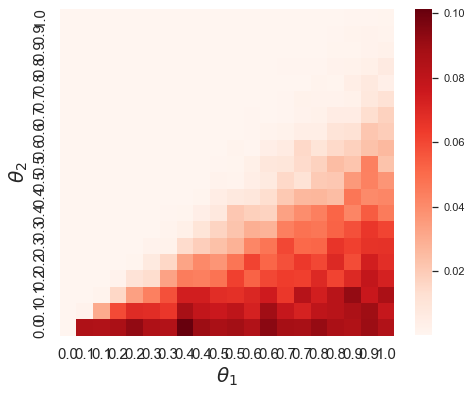

In [41]:
cost_real = np.load("data/temporal_sir_cost_fig1.npy")

beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)
sns.set(style="white")

plt.figure(figsize=(7.5, 6))
sns.heatmap(cost_real.T, xticklabels=np.round(beta_range, 1), yticklabels=np.round(gamma_range, 1), annot=False, fmt=".2f", cmap='Reds').invert_yaxis()
plt.xlabel('$\\theta_1$', size=20)
plt.ylabel('$\\theta_2$', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()